<a href="https://colab.research.google.com/github/Bish-Soli/MQP/blob/main/MQP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset,random_split
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from __future__ import print_function
from sklearn.metrics import f1_score
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
from PIL import Image
import tarfile

In [ ]:
!pip install tensorboard_logger

# CIFAR 10-LT AND CIFAR 100-LT

##Creating the imbalanced dataset and the dataloaders

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class ImbalanceCIFAR(Dataset):
    def __init__(self, cifar_version=10, root='./data', train=True, transform=None, imbalance_ratio=0.01):
        super(ImbalanceCIFAR, self).__init__()
        if cifar_version == 10:
            self.original_dataset = torchvision.datasets.CIFAR10(root=root, train=train, download=True, transform=transform)
        elif cifar_version == 100:
            self.original_dataset = torchvision.datasets.CIFAR100(root=root, train=train, download=True, transform=transform)
        else:
            raise ValueError("CIFAR version must be 10 or 100")

        self.num_classes = 10 if cifar_version == 10 else 100
        self._create_long_tailed(imbalance_ratio)

    def _create_long_tailed(self, imbalance_ratio):
        # Get class distribution
        class_counts = np.bincount([label for _, label in self.original_dataset])
        # Compute number of samples for least represented class
        #num_samples_lt = [int(count * imbalance_ratio) for count in class_counts]
        # Compute number of samples for each class with exponential decrease
        max_count = max(class_counts)

        num_samples_lt = [int(max_count * (imbalance_ratio ** (i / (self.num_classes - 1.0)))) for i in range(self.num_classes)]
        self.indices = []
        for i in range(self.num_classes):
            class_indices = np.where(np.array(self.original_dataset.targets) == i)[0]
            np.random.shuffle(class_indices)
            selected_indices = class_indices[:num_samples_lt[i]]
            self.indices.extend(selected_indices)
        np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        return self.original_dataset[real_idx]

    def get_class_distribution(self):
        class_counts = np.bincount([self.original_dataset.targets[idx] for idx in self.indices])
        return {i: class_counts[i] for i in range(self.num_classes)}

    def get_class_names(self):
        return self.original_dataset.classes

    def plot_class_distribution(self):
        # distribution = self.get_class_distribution()
        # minority_class = min(distribution, key=distribution.get)  # Get the class with the minimum number of samples
        # bars = plt.bar(distribution.keys(), distribution.values())
        # # Highlight the minority class with a different color
        # bars[minority_class].set_color('y')  # Set to red or any color of your choice
        # plt.bar(distribution.keys(), distribution.values())
        # plt.xlabel('Class')
        # plt.ylabel('Number of samples')
        # plt.title('Class Distribution in Dataset')
        # plt.show()
        distribution = self.get_class_distribution()
        # Sort classes by the number of samples per class
        sorted_classes = sorted(distribution.items(), key=lambda item: item[1], reverse=True)

        # Separate the class indices and their corresponding counts
        sorted_indices, sorted_counts = zip(*sorted_classes)

        # Determine the threshold for minority classes, for example, you might define it as the lower 20%
        threshold = np.percentile(sorted_counts, 30)

        # Create a line plot for class distribution
        plt.plot(sorted_indices, sorted_counts, label='Class Distribution')

        # Fill the area under the curve
        plt.fill_between(sorted_indices, sorted_counts, where=(np.array(sorted_counts) <= threshold), color='red', alpha=0.5, label='Minority classes')
        plt.fill_between(sorted_indices, sorted_counts, where=(np.array(sorted_counts) > threshold), color='green', alpha=0.5, label='Majority classes')

        # Add labels and title
        plt.xlabel('Sorted class indices (Large → Small)')
        plt.ylabel('Training samples per class')
        plt.title('Class Distribution in Dataset')
        plt.legend()

        # Show the plot
        plt.show()

    def get_samples_from_each_class(self, num_samples=1):
        samples = {}
        for i in range(self.num_classes):
            class_indices = [idx for idx in self.indices if self.original_dataset.targets[idx] == i]
            np.random.shuffle(class_indices)
            samples[i] = [self.original_dataset[class_indices[j]] for j in range(num_samples)]
        return samples

    def imshow(img):
        img = img.numpy().transpose((1, 2, 0))  # Convert from tensor image
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        img = std * img + mean  # Unnormalize
        img = np.clip(img, 0, 1)  # Clip to [0, 1]
        plt.imshow(img)
        plt.show()

    def show_augmented_images(self, image_index, augmentations, num_samples=5):
        original_image, _ = self.original_dataset[image_index]
        images = [augmentations(original_image) for _ in range(num_samples)]
        grid_image = torchvision.utils.make_grid(images, nrow=num_samples)
        self.imshow(grid_image)


    def compute_imbalance_ratio(self):
        class_distribution = self.get_class_distribution()
        max_count = max(class_distribution.values())
        min_count = min(class_distribution.values())
        return max_count / min_count

    def get_random_batch(self, batch_size=32):
        indices = np.random.choice(self.indices, batch_size, replace=False)
        return [self.original_dataset[idx] for idx in indices]

    def extract_features_and_labels(dataset):
        features = []
        labels = []

        for img, label in dataset:
        # Flatten the image and convert to numpy array
          flattened_img = torch.flatten(img).numpy()
          features.append(flattened_img)
          labels.append(label)

        return np.array(features), np.array(labels)

    def visualize_with_tsne(features, labels, class_names):
        tsne = TSNE(n_components=2, random_state=123)
        tsne_results = tsne.fit_transform(features)

        plt.figure(figsize=(10, 8))
        for i, class_name in enumerate(class_names):
            indices = labels == i
            plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=class_name)
        plt.legend()
        plt.title('t-SNE visualization of the dataset')
        plt.xlabel('t-SNE feature 1')
        plt.ylabel('t-SNE feature 2')
        plt.show()

    def visualize_with_pca(features, labels, class_names):
        pca = PCA(n_components=2)
        pca_results = pca.fit_transform(features)

        plt.figure(figsize=(10, 8))
        for i, class_name in enumerate(class_names):
          indices = labels == i
          plt.scatter(pca_results[indices, 0], pca_results[indices, 1], label=class_name)
        plt.legend()
        plt.title('PCA visualization of the dataset')
        plt.xlabel('PCA feature 1')
        plt.ylabel('PCA feature 2')
        plt.show()




class ImbalanceCIFAR10(ImbalanceCIFAR):
    def __init__(self, root='./data', train=True, transform=None, imbalance_ratio=0.1):
        super(ImbalanceCIFAR10, self).__init__(cifar_version=10, root=root, train=train, transform=transform, imbalance_ratio=imbalance_ratio)


class ImbalanceCIFAR100(ImbalanceCIFAR):
    def __init__(self, root='./data', train=True, transform=None, imbalance_ratio=0.1):
        super(ImbalanceCIFAR100, self).__init__(cifar_version=100, root=root, train=train, transform=transform, imbalance_ratio=imbalance_ratio)

# Define the image transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Initialize the datasets
cifar10_lt = ImbalanceCIFAR10(train=True, transform=transform, imbalance_ratio=0.1)
cifar100_lt = ImbalanceCIFAR100(train=True, transform=transform, imbalance_ratio=0.02)
cifar10_test = ImbalanceCIFAR10(train=False, transform=test_transform, imbalance_ratio=1)  # imbalance_ratio=1 to keep original distribution
cifar100_test = ImbalanceCIFAR100(train=False, transform=test_transform, imbalance_ratio=1)  # imbalance_ratio=1 to keep original distribution

# Define the size of the validation set
val_size_cifar10 = int(0.2 * len(cifar10_lt))  # e.g., 20% of the training data
train_size_cifar10 = len(cifar10_lt) - val_size_cifar10

val_size_cifar100 = int(0.2 * len(cifar100_lt))  # e.g., 20% of the training data
train_size_cifar100 = len(cifar100_lt) - val_size_cifar100

# Split the datasets
cifar10_lt_train, cifar10_lt_val = random_split(cifar10_lt, [train_size_cifar10, val_size_cifar10])
cifar100_lt_train, cifar100_lt_val = random_split(cifar100_lt, [train_size_cifar100, val_size_cifar100])

# Initialize data loaders for training
train_loader_cifar10_lt = DataLoader(cifar10_lt_train, batch_size=4, shuffle=True)
train_loader_cifar100_lt = DataLoader(cifar100_lt_train, batch_size=4, shuffle=True)

# Create validation DataLoaders
val_loader_cifar10_lt = DataLoader(cifar10_lt_val, batch_size=4, shuffle=False)
val_loader_cifar100_lt = DataLoader(cifar100_lt_val, batch_size=4, shuffle=False)

# Create testing DataLoaders
test_loader_cifar10_lt = DataLoader(cifar10_test, batch_size=4, shuffle=False)
test_loader_cifar100_lt = DataLoader(cifar100_test, batch_size=4, shuffle=False)



cpu
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
num_samples_cifar10 = len(cifar10_lt)
num_samples_cifar100 = len(cifar100_lt)

In [ ]:
print(num_samples_cifar10)
print(num_samples_cifar100)

20431
12608


In [ ]:
cifar10_lt.plot_class_distribution()

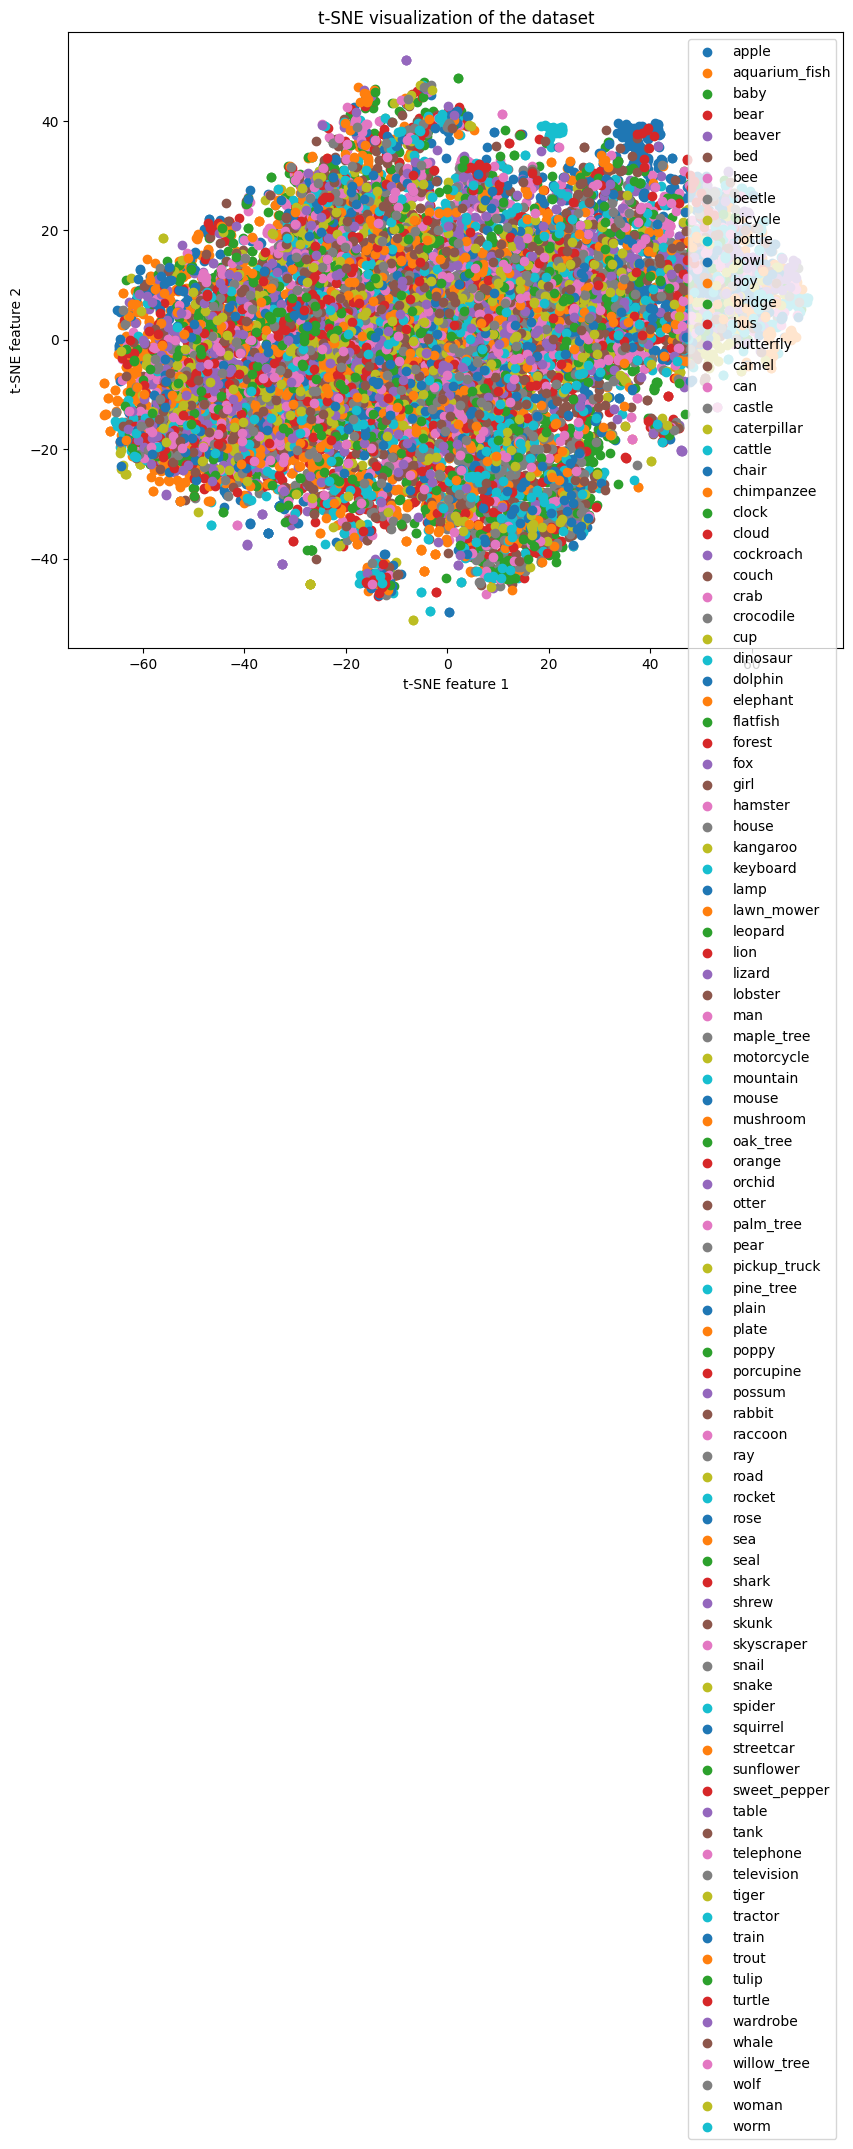

In [ ]:
# Extract features and labels from the dataset
features, labels = ImbalanceCIFAR100.extract_features_and_labels(cifar100_lt)
class_names = cifar100_lt.get_class_names()
# Apply t-SNE
ImbalanceCIFAR100.visualize_with_tsne(features, labels, class_names=class_names)




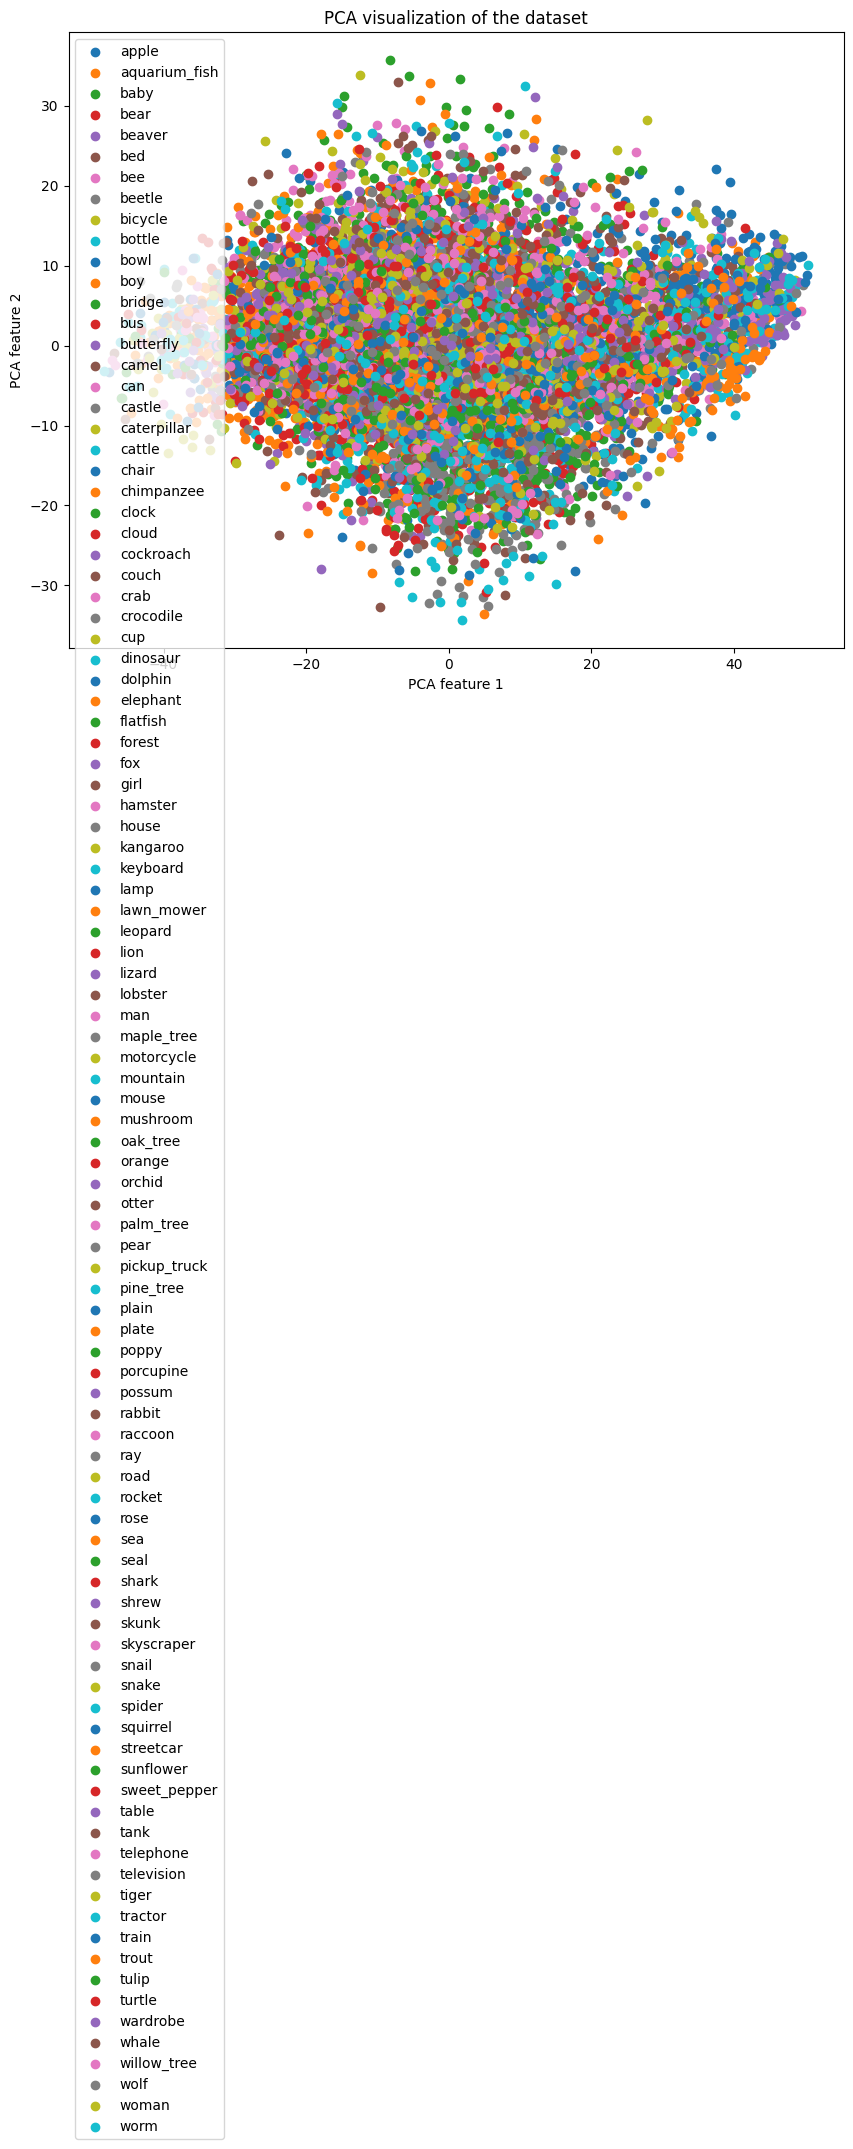

In [ ]:
ImbalanceCIFAR100.visualize_with_pca(features, labels, class_names=class_names)

#Imagenet-LT

##Dataloader

In [ ]:
# Step 1: Extract the Dataset
# Assuming 'ImageNet_LT_open.tar.gz' is the path to your tar.gz file
tar_path = '/content/ImageNet_LT_open.tar.gz'
extract_path = '/content/data'

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://github.com/facebookresearch/classifier-balancing/blob/main/data/dataloader.py

In [53]:
"""Copyright (c) Facebook, Inc. and its affiliates.
All rights reserved.

This source code is licensed under the license found in the
LICENSE file in the root directory of this source tree.

Portions of the source code are from the OLTR project which
notice below and in LICENSE in the root directory of
this source tree.

Copyright (c) 2019, Zhongqi Miao
All rights reserved.
"""


import numpy as np
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import os
from PIL import Image

# Image statistics
RGB_statistics = {
    'iNaturalist18': {
        'mean': [0.466, 0.471, 0.380],
        'std': [0.195, 0.194, 0.192]
    },
    'default': {
        'mean': [0.485, 0.456, 0.406],
        'std':[0.229, 0.224, 0.225]
    }
}

# Data transformation with augmentation
def get_data_transform(split, rgb_mean, rbg_std, key='default'):
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(rgb_mean, rbg_std)
        ]) if key == 'iNaturalist18' else transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0),
            transforms.ToTensor(),
            transforms.Normalize(rgb_mean, rbg_std)
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(rgb_mean, rbg_std)
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(rgb_mean, rbg_std)
        ])
    }
    return data_transforms[split]

# Dataset
class LT_Dataset(Dataset):

    def __init__(self, root, txt, transform=None): #when we want to use the cointrastive learning we change it to Twocroptransform
        self.img_path = []
        self.labels = []
        self.transform = transform
        with open(txt) as f:
            for line in f:
                self.img_path.append(os.path.join(root, line.split()[0]))
                self.labels.append(int(line.split()[1]))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        path = self.img_path[index]
        label = self.labels[index]

        with open(path, 'rb') as f:
            sample = Image.open(f).convert('RGB')

        if self.transform is not None:
            sample = self.transform(sample)

        return sample, label, index

# Load datasets
def load_data(data_root , dataset, phase, batch_size, sampler_dic=None, num_workers=4, test_open=False, shuffle=True):

    if phase == 'train_plain':
        txt_split = 'train'
    elif phase == 'train_val':
        txt_split = 'val'
        phase = 'train'
    else:
        txt_split = phase
    txt = '%s/data/%s/%s_%s.txt'%(data_root,dataset, dataset, txt_split)
    # txt = './data/%s/%s_%s.txt'%(dataset, dataset, (phase if phase != 'train_plain' else 'train'))

    print('Loading data from %s' % (txt))

    if dataset == 'iNaturalist18':
        print('===> Loading iNaturalist18 statistics')
        key = 'iNaturalist18'
    else:
        key = 'default'
    rgb_mean, rgb_std = RGB_statistics[key]['mean'], RGB_statistics[key]['std']

    if phase not in ['train', 'val']:
        transform = get_data_transform('test', rgb_mean, rgb_std, key)
    else:
        transform = get_data_transform(phase, rgb_mean, rgb_std, key)

    print('Use data transformation:', transform)

    set_ = LT_Dataset(data_root, txt, transform)
    print(len(set_))
    if phase == 'test' and test_open:
        open_txt = '%s/data/%s/%s_open.txt'%(data_root,dataset, dataset)
        print('Testing with opensets from %s'%(open_txt))
        open_set_ = LT_Dataset('%s/data/%s/%s_open'%(data_root,dataset, dataset), open_txt, transform)
        set_ = ConcatDataset([set_, open_set_])

    if sampler_dic and phase == 'train':
        print('Using sampler: ', sampler_dic['sampler'])
        # print('Sample %s samples per-class.' % sampler_dic['num_samples_cls'])
        print('Sampler parameters: ', sampler_dic['params'])
        return DataLoader(dataset=set_, batch_size=batch_size, shuffle=False,
                           sampler=sampler_dic['sampler'](set_, **sampler_dic['params']),
                           num_workers=num_workers)
    else:
        print('No sampler.')
        print('Shuffle is %s.' % (shuffle))
        return DataLoader(dataset=set_, batch_size=batch_size,
                          shuffle=shuffle, num_workers=num_workers)

###loading ImageNet data

In [54]:
from pickle import TRUE
splits = ['train','test' ,'val' ]
test_split = 'val'

data_root ='/content/drive/MyDrive/ImageNet-LT'
data = {x:load_data(data_root=data_root,
                                    dataset='ImageNet_LT', phase=x,
                                    batch_size=32,
                                    sampler_dic=None,
                                    test_open=True,
                                    num_workers=2,
                                    shuffle=False)
            for x in splits}

Loading data from /content/drive/MyDrive/ImageNet-LT/data/ImageNet_LT/ImageNet_LT_train.txt
Use data transformation: Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
115846
No sampler.
Shuffle is False.
Loading data from /content/drive/MyDrive/ImageNet-LT/data/ImageNet_LT/ImageNet_LT_test.txt
Use data transformation: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
50000
Testing with opensets from /content/drive/MyDrive/ImageNet-LT/data/ImageNet_LT/ImageNet_LT_open.txt
No sampler.
Shuffle is False.
Loading data from /content/drive/MyDrive/ImageNet-L

In [77]:
import tarfile
import os
dataset='ImageNet_LT'
def extract_tar_gz(file_path, extract_path='.'):
    if file_path.endswith('.tar.gz'):
        with tarfile.open(file_path, 'r:gz') as tar:
            tar.extractall(path=extract_path)
            print(f'Extracted {file_path} to {extract_path}')
    else:
        print('The file is not a .tar.gz file.')

file_path = f'{data_root}/data/{dataset}/{dataset}_open.tar.gz'
extract_path = './data'  # replace with your desired extract path

extract_tar_gz(file_path, extract_path)

Extracted /content/drive/MyDrive/ImageNet-LT/data/ImageNet_LT/ImageNet_LT_open.tar.gz to ./data


In [59]:
print(len(data['train']))
print(len(data['test']))

ImageNet_LT_train_dataloader = data['train']
ImageNet_LT_test_dataloader = data['test']
ImageNet_LT_val_dataloader = data['val']


3621
2125


#Metric Learning

In [70]:


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, weight_normalization = False):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.weight_normalization = weight_normalization


    def forward(self, x):
        if self.weight_normalization == True:
           self.max_norm_(self.conv.weight)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x= self.pool(x)

        return x

    def max_norm_(self, w, _max_norm_val = 3):
      with torch.no_grad():
        norm = w.norm(2, dim=0, keepdim=True).clamp(min=_max_norm_val / 2)
        desired = torch.clamp(norm, max=_max_norm_val)
        w *= (desired / norm)



class Net(nn.Module):
    def __init__(self, weight_normalization = False):
        super().__init__()
        #self.backbone = # Load in a pre-trained Resnet, remove the last layer (fine tune the resnet)
        # resnet -> 2048
        self.conv1 = ConvBlock(3, 6, 5, weight_normalization=weight_normalization)
        self.conv2 = ConvBlock(6, 16, 5, weight_normalization=weight_normalization)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x





In [71]:
class ClassSetup:

  def __init__(self,lr = 0.001, weight_decay=0, weight_normalization= False,opt='Adam', loss_type = 'metric'):
    self.weight_decay = weight_decay
    self.weight_normalization = weight_normalization
    self.lr = lr
    self.model = Net(weight_normalization)
    self.opt = self.get_optimizer(opt)
    self.loss = self.get_loss(loss_type)


  def get_optimizer(self, opt):
    if opt == 'Adam':
      return torch.optim.Adam(self.model.parameters(), lr = self.lr, weight_decay = self.weight_decay)
    else:
     return torch.optim.SGD(self.model.parameters(), lr = self.lr, weight_decay = self.weight_decay)

  def get_loss(self, loss_type):
    if loss_type =='metric':
      return nn.CrossEntropyLoss()
    # elif self.loss_type == 'contrastive':
    #   self.loss = ContrastiveLoss()
    # else
    #   self.loss = Hybrid()

  def get_all (self):
    return self.opt, self.loss, self.model




In [ ]:


# class SupConLoss(nn.Module):
#     """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
#     It also supports the unsupervised contrastive loss in SimCLR"""
#     def __init__(self, temperature=0.07, contrast_mode='all',
#                  base_temperature=0.07):
#         super(SupConLoss, self).__init__()
#         self.temperature = temperature
#         self.contrast_mode = contrast_mode
#         self.base_temperature = base_temperature

#     def forward(self, features, labels=None, mask=None):
#         """Compute loss for model. If both `labels` and `mask` are None,
#         it degenerates to SimCLR unsupervised loss:
#         https://arxiv.org/pdf/2002.05709.pdf

#         Args:
#             features: hidden vector of shape [bsz, n_views, ...].
#             labels: ground truth of shape [bsz].
#             mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
#                 has the same class as sample i. Can be asymmetric.
#         Returns:
#             A loss scalar.
#         """
#         device = (torch.device('cuda')
#                   if features.is_cuda
#                   else torch.device('cpu'))

#         if len(features.shape) < 3:
#             raise ValueError('`features` needs to be [bsz, n_views, ...],'
#                              'at least 3 dimensions are required')
#         if len(features.shape) > 3:
#             features = features.view(features.shape[0], features.shape[1], -1)

#         batch_size = features.shape[0]
#         if labels is not None and mask is not None:
#             raise ValueError('Cannot define both `labels` and `mask`')
#         elif labels is None and mask is None:
#             mask = torch.eye(batch_size, dtype=torch.float32).to(device)
#         elif labels is not None:
#             labels = labels.contiguous().view(-1, 1)
#             if labels.shape[0] != batch_size:
#                 raise ValueError('Num of labels does not match num of features')
#             mask = torch.eq(labels, labels.T).float().to(device)
#         else:
#             mask = mask.float().to(device)

#         contrast_count = features.shape[1]
#         contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
#         if self.contrast_mode == 'one':
#             anchor_feature = features[:, 0]
#             anchor_count = 1
#         elif self.contrast_mode == 'all':
#             anchor_feature = contrast_feature
#             anchor_count = contrast_count
#         else:
#             raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

#         # compute logits
#         anchor_dot_contrast = torch.div(
#             torch.matmul(anchor_feature, contrast_feature.T),
#             self.temperature)
#         # for numerical stability
#         logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
#         logits = anchor_dot_contrast - logits_max.detach()

#         # tile mask
#         mask = mask.repeat(anchor_count, contrast_count)
#         # mask-out self-contrast cases
#         logits_mask = torch.scatter(
#             torch.ones_like(mask),
#             1,
#             torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
#             0
#         )
#         mask = mask * logits_mask

#         # compute log_prob
#         exp_logits = torch.exp(logits) * logits_mask
#         log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

#         # compute mean of log-likelihood over positive
#         # modified to handle edge cases when there is no positive pair
#         # for an anchor point.
#         # Edge case e.g.:-
#         # features of shape: [4,1,...]
#         # labels:            [0,1,1,2]
#         # loss before mean:  [nan, ..., ..., nan]
#         mask_pos_pairs = mask.sum(1)
#         mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)
#         mean_log_prob_pos = (mask * log_prob).sum(1) / mask_pos_pairs

#         # loss
#         loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
#         loss = loss.view(anchor_count, batch_size).mean()

#         return loss

In [72]:
net = Net()
setup = ClassSetup(weight_normalization=True, weight_decay=1e-4)
optimizer, criterion, net = setup.get_all()
net.to(device)

Net(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): ConvBlock(
    (conv): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [73]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0


In [78]:
early_stopping = EarlyStopping(patience=5, min_delta=0.001)
# supcon_loss = SupConLoss(temperature=0.07, contrast_mode='all', base_temperature=0.07)
print_every_batches = 1000  # subject to change from 2000->1000 to print down there

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0

    net.train()  # Set the model to training mode

    for i, data in enumerate(ImageNet_LT_train_dataloader, 0): #train_loader_cifar10_lt
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs.to(device)
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #     running_loss = 0.0
        if i % print_every_batches == print_every_batches - 1:    # Adjust this condition
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_every_batches:.3f}')
            #running_loss = 0.0
    # print(f'End of Epoch {epoch + 1}, loss: {running_loss / len(train_loader_cifar10_lt):.3f}')
    training_loss = running_loss / len(ImageNet_LT_train_dataloader)
    # print(f'End of Epoch {epoch + 1}, Training Loss: {training_loss:.3f}')

    # Calculate validation loss
    val_loss = 0.0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for val_inputs, val_labels in ImageNet_LT_val_dataloader:# val_loader_cifar10_lt
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = net(val_inputs)
            v_loss = criterion(val_outputs, val_labels)
            val_loss += v_loss.item()

    val_loss /= len(ImageNet_LT_val_dataloader) # val_loader_cifar10_lt
    print(f'End of Epoch {epoch + 1}, Training Loss: {running_loss / len(ImageNet_LT_train_dataloader):.3f}, Validation Loss: {val_loss:.3f}') #train_loader_cifar10_lt
    running_loss = 0.0

    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print('Finished Training')

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-53-d5197df1bfab>", line 85, in __getitem__
    with open(path, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ImageNet-LT/train/n01440764/n01440764_190.JPEG'


In [ ]:
net.eval()  # Set the model to evaluation mode
total = 0
correct = 0
with torch.no_grad():
    for data in test_loader_cifar10_lt:  # using CIFAR10 test loader as an example
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

# Contrastive Learning
https://github.com/HobbitLong/SupContrast/tree/master

##resnet_big.py

In [ ]:
"""ResNet in PyTorch.
ImageNet-Style ResNet
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
Adapted from: https://github.com/bearpaw/pytorch-classification
"""


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(BasicBlock, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(Bottleneck, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channel=3, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves
        # like an identity. This improves the model by 0.2~0.3% according to:
        # https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            stride = strides[i]
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, layer=100):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return out


def resnet18(**kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)


def resnet34(**kwargs):
    return ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)


def resnet50(**kwargs):
    return ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)


def resnet101(**kwargs):
    return ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)


model_dict = {
    'resnet18': [resnet18, 512],
    'resnet34': [resnet34, 512],
    'resnet50': [resnet50, 2048],
    'resnet101': [resnet101, 2048],
}


class LinearBatchNorm(nn.Module):
    """Implements BatchNorm1d by BatchNorm2d, for SyncBN purpose"""
    def __init__(self, dim, affine=True):
        super(LinearBatchNorm, self).__init__()
        self.dim = dim
        self.bn = nn.BatchNorm2d(dim, affine=affine)

    def forward(self, x):
        x = x.view(-1, self.dim, 1, 1)
        x = self.bn(x)
        x = x.view(-1, self.dim)
        return x


class SupConResNet(nn.Module):
    """backbone + projection head"""
    def __init__(self, name='resnet50', head='mlp', feat_dim=128, num_classes = 10):
        super(SupConResNet, self).__init__()
        model_fun, dim_in = model_dict[name]
        self.encoder = model_fun()
        self.num_classes = num_classes
        self.fc = nn.Linear(feat_dim, num_classes)
        if head == 'linear':
            self.head = nn.Linear(dim_in, feat_dim)
        elif head == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(dim_in, dim_in),
                nn.ReLU(inplace=True),
                nn.Linear(dim_in, feat_dim)
            )
        else:
            raise NotImplementedError(
                'head not supported: {}'.format(head))

    def forward(self, x):

        feat = self.encoder(x)
        feat = F.normalize(self.head(feat), dim=1)
        bsz = int(feat.shape[0]/2)
        f1, f2 = torch.split(feat, [bsz, bsz], dim=0)
        x = self.fc(f1)
        return feat, x


class SupCEResNet(nn.Module):
    """encoder + classifier"""
    def __init__(self, name='resnet50', num_classes=10):
        super(SupCEResNet, self).__init__()
        model_fun, dim_in = model_dict[name]
        self.encoder = model_fun()
        self.fc = nn.Linear(dim_in, num_classes)

    def forward(self, x):
        return self.fc(self.encoder(x))


class LinearClassifier(nn.Module):
    """Linear classifier"""
    def __init__(self, name='resnet50', num_classes=10):
        super(LinearClassifier, self).__init__()
        _, feat_dim = model_dict[name]
        self.fc = nn.Linear(feat_dim, num_classes)

    def forward(self, features):
        return self.fc(features)

##Losses.py

In [ ]:
"""
Author: Yonglong Tian (yonglong@mit.edu)
Date: May 07, 2020
"""

class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        # modified to handle edge cases when there is no positive pair
        # for an anchor point.
        # Edge case e.g.:-
        # features of shape: [4,1,...]
        # labels:            [0,1,1,2]
        # loss before mean:  [nan, ..., ..., nan]
        mask_pos_pairs = mask.sum(1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_pos_pairs

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

##Util.py

In [ ]:
class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def adjust_learning_rate(args, optimizer, epoch):
    lr = args.learning_rate
    if args.cosine:
        eta_min = lr * (args.lr_decay_rate ** 3)
        lr = eta_min + (lr - eta_min) * (
                1 + math.cos(math.pi * epoch / args.epochs)) / 2
    else:
        steps = np.sum(epoch > np.asarray(args.lr_decay_epochs))
        if steps > 0:
            lr = lr * (args.lr_decay_rate ** steps)

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def warmup_learning_rate(args, epoch, batch_id, total_batches, optimizer):
    if args.warm and epoch <= args.warm_epochs:
        p = (batch_id + (epoch - 1) * total_batches) / \
            (args.warm_epochs * total_batches)
        lr = args.warmup_from + p * (args.warmup_to - args.warmup_from)

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


def set_optimizer(opt, model):
    optimizer = optim.SGD(model.parameters(),
                          lr=opt.learning_rate,
                          momentum=opt.momentum,
                          weight_decay=opt.weight_decay)
    return optimizer


def save_model(model, optimizer, opt, epoch, save_file):
    print('==> Saving...')
    state = {
        'opt': opt,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
    }
    torch.save(state, save_file)
    del state

##Main_supcon.py

In [ ]:
from __future__ import print_function

import sys
import argparse
import time
import math

import tensorboard_logger as tb_logger

import torch.backends.cudnn as cudnn


import argparse
import os
import math

def parse_option(batch_size=32, epochs=10, print_freq=2, save_freq=9, num_workers=16,
                 learning_rate=0.05, lr_decay_epochs='700,800,900', lr_decay_rate=0.1,
                 weight_decay=1e-4, momentum=0.9, model='resnet50', dataset='cifar10',
                 mean=None, std=None, data_folder=None, size=32, method='SupCon',
                 temp=0.07, cosine=False, syncBN=False, warm=False, trial='0'):
    class Option(object):
        pass

    opt = Option()

    # Set values
    opt.batch_size = batch_size
    opt.epochs = epochs
    opt.print_freq = print_freq
    opt.save_freq = save_freq
    opt.num_workers = num_workers
    opt.learning_rate = learning_rate
    opt.lr_decay_epochs = lr_decay_epochs
    opt.lr_decay_rate = lr_decay_rate
    opt.weight_decay = weight_decay
    opt.momentum = momentum
    opt.model = model
    opt.dataset = dataset
    opt.mean = mean
    opt.std = std
    opt.data_folder = data_folder
    opt.size = size
    opt.method = method
    opt.temp = temp
    opt.cosine = cosine
    opt.syncBN = syncBN
    opt.warm = warm
    opt.trial = trial

    # Additional processing as in the original function
    if opt.dataset == 'path':
        assert opt.data_folder is not None and opt.mean is not None and opt.std is not None

    if opt.data_folder is None:
        opt.data_folder = './datasets/'

    opt.model_path = './save/SupCon/{}_models'.format(opt.dataset)
    opt.tb_path = './save/SupCon/{}_tensorboard'.format(opt.dataset)

    iterations = opt.lr_decay_epochs.split(',')
    opt.lr_decay_epochs = [int(it) for it in iterations]

    opt.model_name = '{}_{}_{}_lr_{}_decay_{}_bsz_{}_temp_{}_trial_{}'.format(
        opt.method, opt.dataset, opt.model, opt.learning_rate,
        opt.weight_decay, opt.batch_size, opt.temp, opt.trial)

    if opt.cosine:
        opt.model_name = '{}_cosine'.format(opt.model_name)

    if opt.batch_size > 256:
        opt.warm = True
    if opt.warm:
        opt.model_name = '{}_warm'.format(opt.model_name)
        opt.warmup_from = 0.01
        opt.warm_epochs = 10
        if opt.cosine:
            eta_min = opt.learning_rate * (opt.lr_decay_rate ** 3)
            opt.warmup_to = eta_min + (opt.learning_rate - eta_min) * \
                (1 + math.cos(math.pi * opt.warm_epochs / opt.epochs)) / 2
        else:
            opt.warmup_to = opt.learning_rate

    opt.tb_folder = os.path.join(opt.tb_path, opt.model_name)
    if not os.path.isdir(opt.tb_folder):
        os.makedirs(opt.tb_folder)

    opt.save_folder = os.path.join(opt.model_path, opt.model_name)
    if not os.path.isdir(opt.save_folder):
        os.makedirs(opt.save_folder)

    return opt


def set_loader(opt):
    # construct data loader
    if opt.dataset == 'cifar10':
        mean = (0.4914, 0.4822, 0.4465)
        std = (0.2023, 0.1994, 0.2010)
    elif opt.dataset == 'cifar100':
        mean = (0.5071, 0.4867, 0.4408)
        std = (0.2675, 0.2565, 0.2761)
    elif opt.dataset == 'path':
        mean = eval(opt.mean)
        std = eval(opt.std)
    else:
        raise ValueError('dataset not supported: {}'.format(opt.dataset))
    normalize = transforms.Normalize(mean=mean, std=std)

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=opt.size, scale=(0.2, 1.)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
    ])

    if opt.dataset == 'cifar10':
        train_dataset = datasets.CIFAR10(root=opt.data_folder,
                                         transform=TwoCropTransform(train_transform),
                                         download=True)
    elif opt.dataset == 'cifar100':
        train_dataset = datasets.CIFAR100(root=opt.data_folder,
                                          transform=TwoCropTransform(train_transform),
                                          download=True)
    elif opt.dataset == 'path':
        train_dataset = datasets.ImageFolder(root=opt.data_folder,
                                            transform=TwoCropTransform(train_transform))
    else:
        raise ValueError(opt.dataset)

    train_sampler = None
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=opt.batch_size, shuffle=(train_sampler is None),
        num_workers=opt.num_workers, pin_memory=True, sampler=train_sampler)

    return train_loader


def set_model(opt):
    model = SupConResNet(name=opt.model)
    criterion = SupConLoss(temperature=opt.temp)

    # enable synchronized Batch Normalization
    if opt.syncBN:
        model = apex.parallel.convert_syncbn_model(model)

    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            model.encoder = torch.nn.DataParallel(model.encoder)
        model = model.cuda()
        criterion = criterion.cuda()
        cudnn.benchmark = True

    return model, criterion


def train(train_loader, model, criterion, optimizer, epoch, opt, ALPHA=0.8, BETA=0.2):
    """one epoch training"""
    model.train()

    CE = nn.CrossEntropyLoss()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    end = time.time()
    for idx, (images, labels) in enumerate(train_loader):
        data_time.update(time.time() - end)

        images = torch.cat([images[0], images[1]], dim=0)
        if torch.cuda.is_available():
            images = images.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
        bsz = labels.shape[0]

        # warm-up learning rate
        warmup_learning_rate(opt, epoch, idx, len(train_loader), optimizer)


        # compute loss
        features, x = model(images)
        f1, f2 = torch.split(features, [bsz, bsz], dim=0)
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        if opt.method == 'SupCon':
            SC_Loss = criterion(features, labels)
            CE_Loss = CE(x, labels)
            loss = ALPHA * SC_Loss + BETA * CE_Loss
        elif opt.method == 'SimCLR':
            loss = criterion(features)
        else:
            raise ValueError('contrastive method not supported: {}'.
                             format(opt.method))

        # update metric
        losses.update(loss.item(), bsz)

        # SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # print info
        if (idx + 1) % opt.print_freq == 0:
            print('Train: [{0}][{1}/{2}]\t'
                  'BT {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'DT {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'loss {loss.val:.3f} ({loss.avg:.3f})'.format(
                   epoch, idx + 1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses))
            sys.stdout.flush()

    return losses.avg


def main():
    opt = parse_option()

    # build data loader
    train_loader = set_loader(opt)

    # build model and criterion
    model, criterion = set_model(opt)

    # build optimizer
    optimizer = set_optimizer(opt, model)

    # tensorboard
    logger = tb_logger.Logger(logdir=opt.tb_folder, flush_secs=2)

    # training routine
    for epoch in range(1, opt.epochs + 1):
        adjust_learning_rate(opt, optimizer, epoch)

        # train for one epoch
        time1 = time.time()
        loss = train(train_loader, model, criterion, optimizer, epoch, opt)
        time2 = time.time()
        print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        # tensorboard logger
        logger.log_value('loss', loss, epoch)
        logger.log_value('learning_rate', optimizer.param_groups[0]['lr'], epoch)

        if epoch % opt.save_freq == 0:
            save_file = os.path.join(
                opt.save_folder, 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
            save_model(model, optimizer, opt, epoch, save_file)

    # save the last model
    save_file = os.path.join(
        opt.save_folder, 'last.pth')
    save_model(model, optimizer, opt, opt.epochs, save_file)


In [ ]:
def print_options(opt):
    for attr in dir(opt):
        # Filter out built-in attributes and methods
        if not attr.startswith("__"):
            print(f'{attr}: {getattr(opt, attr)}')

# Call this function to print the options
print_options(opt)

In [ ]:
main()